<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Models-analysis/blob/v1/Tomato_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import os
import json
import shutil
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [38]:
# Upload your kaggle.json first in Colab (use sidebar)

with open("kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip -q tomatoleaf.zip

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)
replace tomato/cnn_train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
# Combine train and val folders into one
combined_path = "/content/tomato-leaf-disease"
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls = os.path.join(source_dir, cls)
        dst_cls = os.path.join(target_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for file in os.listdir(src_cls):
            shutil.copy2(os.path.join(src_cls, file), os.path.join(dst_cls, file))

combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

In [40]:
def count_images(folder_path):
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, cls)
        count = len(os.listdir(path))
        print(f"{cls}: {count} images")
        total += count
    print(f"\nTotal images: {total}")

count_images(combined_path)

def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        for img in os.listdir(os.path.join(folder_path, cls)):
            try:
                with Image.open(os.path.join(folder_path, cls, img)) as im:
                    im.verify()
            except:
                broken.append(os.path.join(cls, img))
    print("Corrupt images:" if broken else "All images OK")
    if broken: print(broken)

check_image_integrity(combined_path)

Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000
All images OK


In [41]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = dataset.class_names
NUM_CLASSES = len(class_names)

# 80/10/10 split
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 11000 files belonging to 10 classes.


In [42]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

In [43]:
from keras.applications import DenseNet121

base_model = DenseNet121(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False  # freeze the base


x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 387ms/step - accuracy: 0.4222 - loss: 1.6924 - val_accuracy: 0.7849 - val_loss: 0.6904
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 347ms/step - accuracy: 0.7372 - loss: 0.7787 - val_accuracy: 0.8456 - val_loss: 0.5135
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 350ms/step - accuracy: 0.8008 - loss: 0.5869 - val_accuracy: 0.8456 - val_loss: 0.4421
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 348ms/step - accuracy: 0.8238 - loss: 0.5180 - val_accuracy: 0.8566 - val_loss: 0.4110
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 97s 352ms/step - accuracy: 0.8389 - loss: 0.4702 - val_accuracy: 0.8768 - val_loss: 0.3567
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 97s 352ms/step - accuracy: 0.8518 - loss: 0.4339 - val_accuracy: 0.8860 - val_loss: 0.3519
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 97s 351ms/step - accuracy: 0.8559 - loss: 0.4276 - val_accuracy: 0.8759 - val_loss: 0.3535
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 143s 355ms/step - accuracy: 0.8782 - loss:

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [ ]:
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC-AUC Score: {auc_score*100:.2f}%")
except Exception as e:
    print("ROC-AUC not available:", e)

In [ ]:
model.save("tomato-leaf-disease_DenseNet121_model.keras")
print("Model saved successfully.")

In [ ]:
import numpy as np
import os
import json
import shutil
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [ ]:
# Upload your kaggle.json first in Colab (use sidebar)

with open("kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip -q tomatoleaf.zip

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 71% 127M/179M [00:00<00:00, 1.32GB/s]
100% 179M/179M [00:00<00:00, 1.14GB/s]


In [ ]:
# Combine train and val folders into one
combined_path = "/content/tomato-leaf-disease"
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls = os.path.join(source_dir, cls)
        dst_cls = os.path.join(target_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for file in os.listdir(src_cls):
            shutil.copy2(os.path.join(src_cls, file), os.path.join(dst_cls, file))

combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

In [ ]:
def count_images(folder_path):
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, cls)
        count = len(os.listdir(path))
        print(f"{cls}: {count} images")
        total += count
    print(f"\nTotal images: {total}")

count_images(combined_path)

def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        for img in os.listdir(os.path.join(folder_path, cls)):
            try:
                with Image.open(os.path.join(folder_path, cls, img)) as im:
                    im.verify()
            except:
                broken.append(os.path.join(cls, img))
    print("Corrupt images:" if broken else "All images OK")
    if broken: print(broken)

check_image_integrity(combined_path)

Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000
All images OK


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = dataset.class_names
NUM_CLASSES = len(class_names)

# 80/10/10 split
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 11000 files belonging to 10 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from keras.applications import DenseNet121

base_model = DenseNet121(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False  # freeze the base


x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 139s 389ms/step - accuracy: 0.4222 - loss: 1.6924 - val_accuracy: 0.7849 - val_loss: 0.6904
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 112s 349ms/step - accuracy: 0.7372 - loss: 0.7787 - val_accuracy: 0.8456 - val_loss: 0.5135
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 95s 343ms/step - accuracy: 0.8008 - loss: 0.5869 - val_accuracy: 0.8456 - val_loss: 0.4421
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 144s 352ms/step - accuracy: 0.8238 - loss: 0.5180 - val_accuracy: 0.8566 - val_loss: 0.4110
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 140s 345ms/step - accuracy: 0.8389 - loss: 0.4702 - val_accuracy: 0.8787 - val_loss: 0.3572
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 98s 353ms/step - accuracy: 0.8498 - loss: 0.4340 - val_accuracy: 0.8851 - val_loss: 0.3556
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 139s 343ms/step - accuracy: 0.8504 - loss: 0.4255 - val_accuracy: 0.8824 - val_loss: 0.3424
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 97s 351ms/step - accuracy: 0.8768 - lo

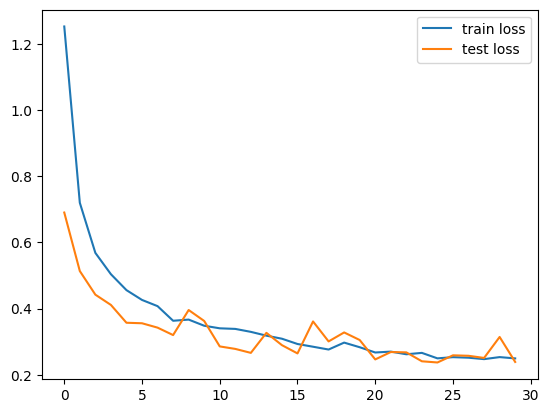

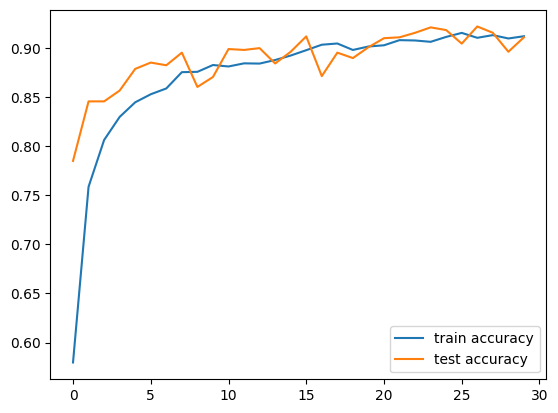

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


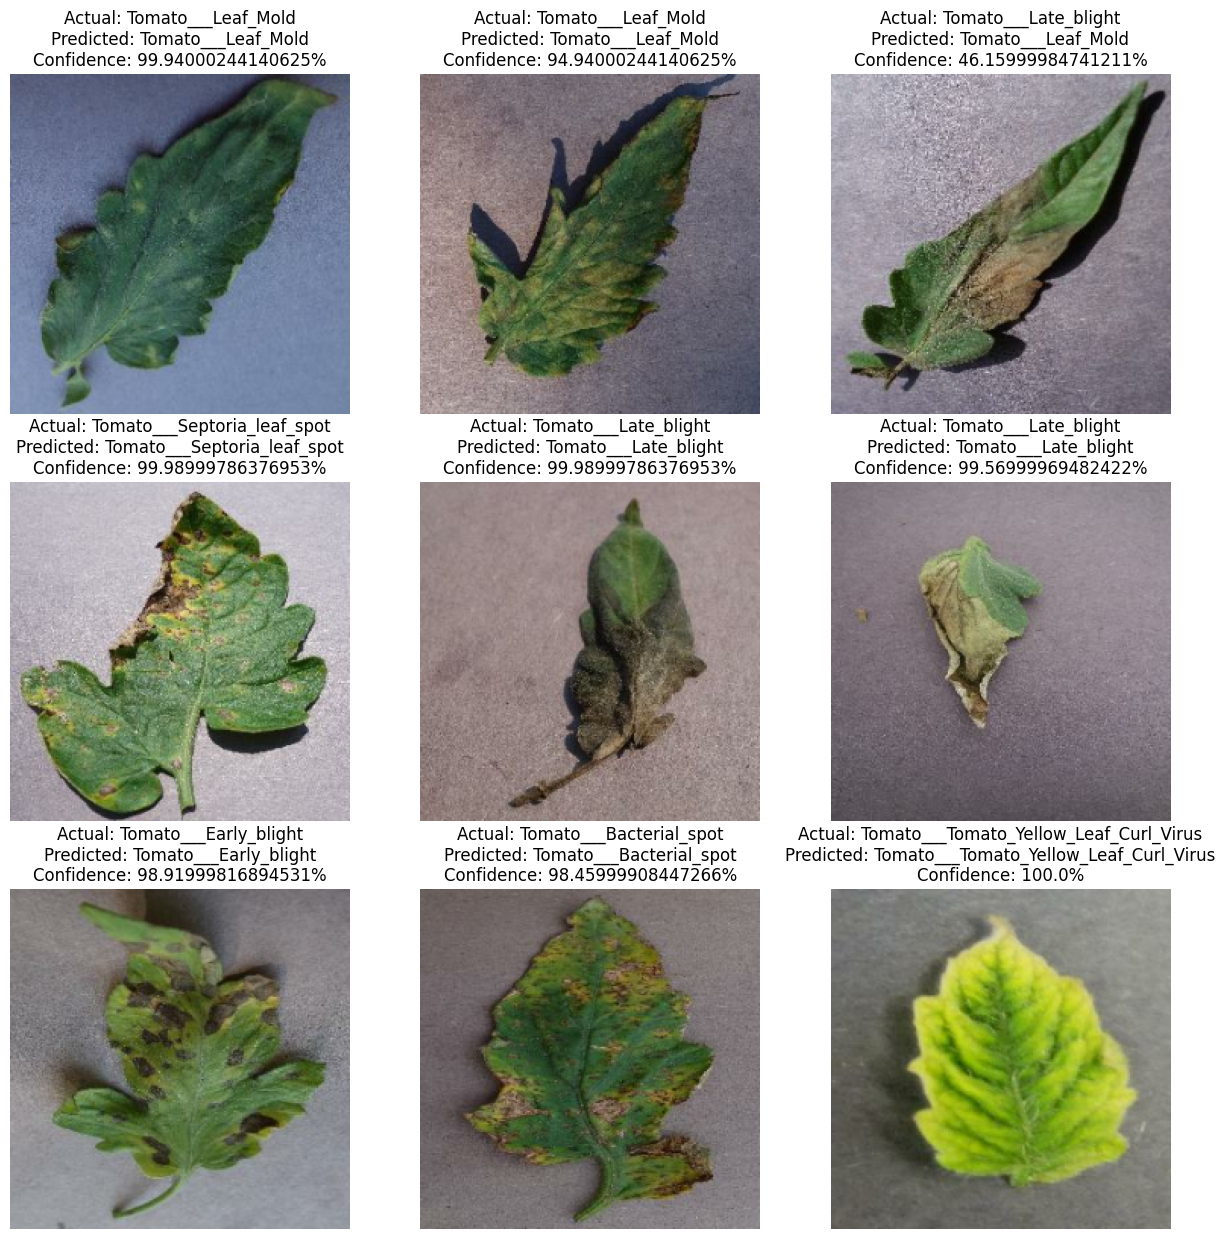

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

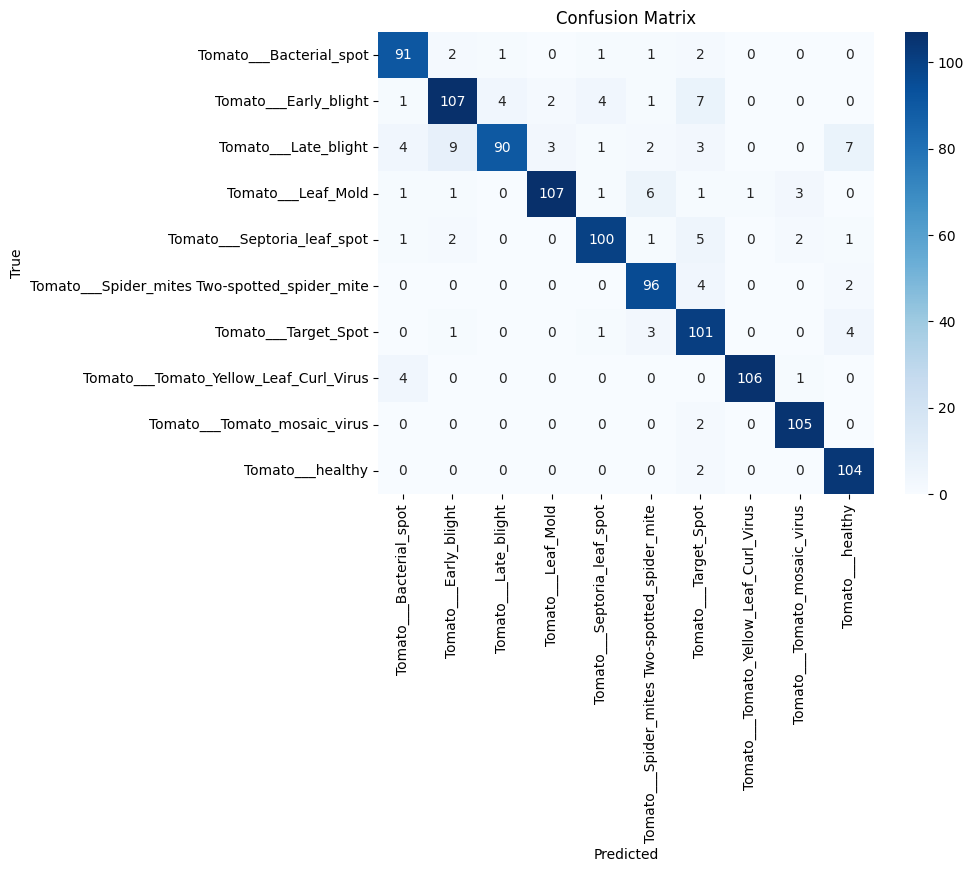

ROC-AUC Score: 99.62%


In [ ]:
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC-AUC Score: {auc_score*100:.2f}%")
except Exception as e:
    print("ROC-AUC not available:", e)

In [ ]:
model.save("tomato-leaf-disease_DenseNet121_model.keras")
print("Model saved successfully.")

Model saved successfully.
